# Prova 2 - Prevendo probabilidade de sobrevivência: Desastre Titanic

In [95]:
import math as math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Definição do Problema


O Titanic era o maior navio em operação na época de sua viagem inaugural e transportava 2.224 pessoas nessa viagem, que partiu de Southampton em 10 de abril de 1912. Seu destino era Nova York, nos Estados Unidos, mas sua última parada foi em Cobh (Queenstown), na Irlanda, em 11 de abril de 1912.

Este conjunto de dados contém os registros de todos os passageiros, incluindo informações sobre sua sobrevivência.


Referências:

- Will Cukierski. (2012). Titanic - Machine Learning from Disaster. Kaggle. https://kaggle.com/competitions/titanic

- https://www.kaggle.com/competitions/titanic

- https://www.kaggle.com/code/nphantawee/learning-classification-problem-with-titanic


In [96]:
# Carregando os dados
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [97]:
# Dando uma olhada inicial nos dados:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Usando o comando .info(), percebemos que:

- as características com natureza numérica são: ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch','Age', 'Fare']
- as características com natureza categórica são: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [98]:
# identificando dados faltantes

df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: >

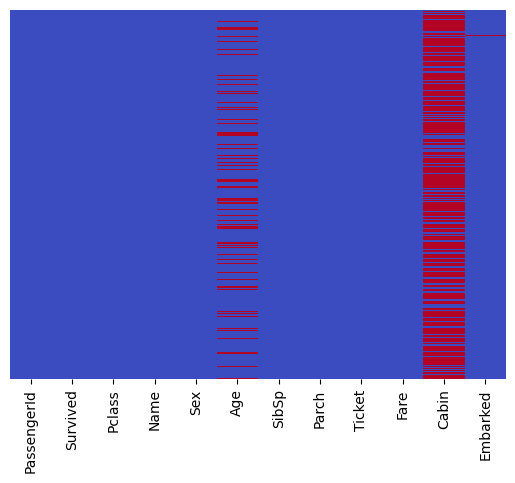

In [99]:
# Verificando a posição desses dados faltantes no conjunto de dados

sns.heatmap(data=df.isna(),yticklabels=False,cmap='coolwarm',cbar=False)

# Dados ausentes: cabine

Existem muitos dados faltantes para a cabine dos passageiros, portanto, iremos remover essa característica.

In [100]:
df.drop(columns=['Cabin'],axis=1,inplace=True)

In [101]:
df.columns # Perceba que a coluna 'Cabin' foi removida do Dataframe

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

# Dados ausentes: local de embarque

Como só dois passageiros não possuem essa característica registrada, iremos preenchê-la com a categoria mais presente (frequente).

<Axes: xlabel='Embarked', ylabel='count'>

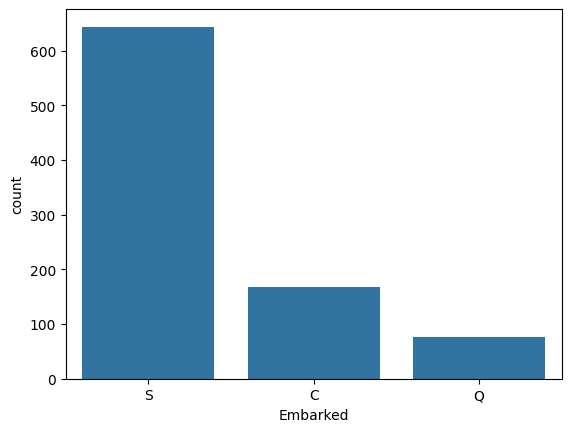

In [102]:
sns.countplot(x=df['Embarked'])

In [103]:
# Também podemos verificar isso calculando a moda:

local_embarque_mais_freq = df['Embarked'].mode()[0]

display(local_embarque_mais_freq)

'S'

In [104]:
# Preenchendo os dados ausentes com o local de embarque mais frequente.
df['Embarked'].fillna(local_embarque_mais_freq, inplace = True)

In [105]:
# Checando se de fato não temos mais dados ausentes associados à essa característica:
df['Embarked'].isna().sum()

0

# Dados ausentes: Idade

É rezoável acreditar que passageiros de diferentes classes (1a, 2a e 3a) podem ter diferentes faixas de renda e idade. Os mais velhos podem ser aqueles que ganham salários mais altos e podem gastar mais. Por isso, iremos agrupar os dados pela classe e preencher os valores com a média de idade associada a cada classe:

/tmp/ipykernel_43268/1790045382.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df,x=df['Pclass'],y=df['Age'],palette='coolwarm')


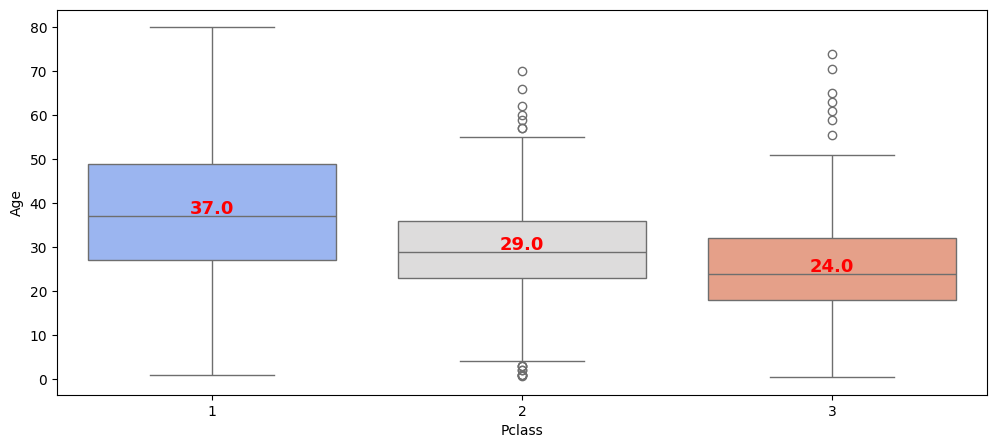

In [106]:
# Agrupa pela classe e encontra a idade média.
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data=df,x=df['Pclass'],y=df['Age'],palette='coolwarm')
medians = df.groupby(['Pclass'])['Age'].median().values # encontra mediada
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick],
            horizontalalignment='center', size=13, color='r', weight='semibold')

In [107]:
# cria uma função para preencher a idade:
def fill_age_na(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [108]:
df['Age'] = df[['Age','Pclass']].apply(fill_age_na,axis=1)

In [109]:
df['Age'].isna().sum() # note que não temos mais dados ausentes associados à idade

0

# Engenharia de Características



In [110]:
# Criando uma nova característica que leva em conta o tamanho do nome do passageiro (em número de caracteres). A ideia é que nomes mais longos podem ser mais difíceis de serem pronunciados e, portanto, numa chamada de emergência, resultar numa maior probabilidade de morte.
df['NameLength'] = df['Name'].apply(len)

<Axes: >

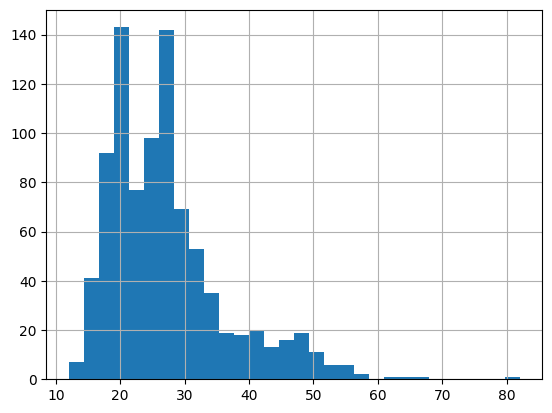

In [111]:
df['NameLength'].hist(bins=30) # A maior parte dos passageiros possuem nomes com cerca de 20 a 30 caracteres

# Eliminando características desnecessárias

Com base nos dados, parece razoável removermos as seguintes características:

- PassengerID: É apenas um identificador do passageiro, sem relevância para a análise.
- Name: O comprimento do nome parece ser mais útil do que o nome em si.
- Ticket: Não parece fazer sentido que o número do Ticket tenha relação com a sobrevivência (a menos que ele possa indicar onde o passageiro estava hospedado na embarcação, mas ignoraremos essa questão nesse script)

In [112]:
cols_drop = ['PassengerId','Name','Ticket']
df.drop(cols_drop, axis=1, inplace = True)

# Análise exploratória dos dados

## Modelo que não se baseia em dados

Sabendo que existem apenas duas classes, $y=0$ ou $y=1$, poderíamos estabelecer um modelo inicial que prevê $\hat{y}=0$ ou $\hat{y}=1$ aleatoriamente. Note que esse modelo foi construído sem qualquer análise em cima dos dados.

Esse modelo teria uma tendência a aprensentar uma taxa de acerto (acurácia) de **50 %**, conforme ilustrado abaixo

In [113]:
m               = df.shape[0] # número de passageiros
y_est_aleatorio = np.random.randint(0, 2, size=(m,))
aux_df          =  df['Survived'] == y_est_aleatorio # Modelo que gera 1's ou 0's aleatoriamente

display(aux_df.mean())

0.4983164983164983

A capacidade de acertar desse modelo com saída aleatória independe do desbalanceamento presente nos dados.


Na sequência desse script, tentaremos obter modelos com uma taxa de acerto maior do que esta.

## Qual foi o percentual de pessoas que sobreviveu ao desastre?

In [114]:
print(df['Survived'].mean())

0.3838383838383838


Veja que apenas 38.38 % das pessoas sobreviveram ao desastre. Esse dado estatístico já poderia ser usado para constituir um modelo aprimorado, que faz sempre a seguinte previsão:

- Independentemente de qualquer característica do passageiro, atribuir uma probabilidade de sobrevivência de 38.38 %.

Nesse sentido, usando um valor de limiar para tomada de decisão de 50 %, como 38.38 % < 50 %, esse modelo nos daria a saída $\hat{y}=0$ independentemente de qualquer característica $x$. Ou seja, o modelo indicaria a morte de todos os passageiros, e sua taxa de acerto (acurácia) seria de 100 % - 38.38 % = **61.62 %**, já que 61.62 % dos passageiros de fato morreram.

## Sexo masculino ou sexo feminino apresentou maior percentual de sobrevivência?

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


<Axes: xlabel='Sex', ylabel='count'>

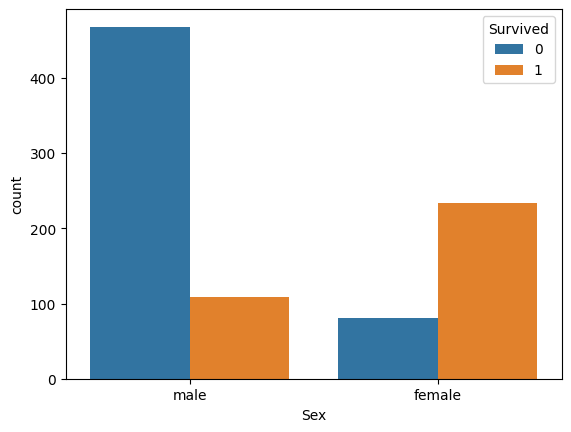

In [115]:
print(df.groupby(['Sex'])['Survived'].mean())
sns.countplot(x=df['Sex'],hue=df['Survived'])

Note que os dados estatísticos acima já poderiam ser usados para constituir um terceiro modelo, que faz a seguinte previsão:

- Caso o passageiro seja do sexo feminino, atribuir uma probabilidade de sobrevivência de 74.2038%

- Caso o passageiro seja do sexo masculino, atribuir uma probabilidade de sobrevivência de 18.8908%

Nesse sentido, usando um valor de limiar para tomada de decisão de 50 %, isso significa que, o modelo sugere $\hat{y}=0$ para sexo masculino e $\hat{y}=1$ para sexo feminino.

Abaixo nós calculamos qual seria a taxa de acerto (acurácia) desse modelo estatístico.

In [116]:
y_df     = df['Survived']
y_est_df = (df['Sex'] == 'female') # atribuirá True para sexo feminino e False para sexo masculino
y_est_df = y_est_df.astype(int)    # transforma True em 1 e False em 0
aux_df   =  y_df == y_est_df

display(aux_df.mean())



0.7867564534231201

Com esse modelo, teríamos uma taxa de acerto (acurácia) de **78.68 %**!




Será que, via algoritmo de aprendizado de máquina, conseguiremos obter um modelo melhor do que este?

A ideia básica consiste em entender que o modelo de aprendizado de máquina gerará uma probabilidade de sobrevivência processando múltiplas características simultaneamente, e não apenas uma.

# Convertendo variáveis categóricas em variáveis numéricas

In [117]:
df.head() # Olhando os dados atuais

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength
0,0,3,male,22.0,1,0,7.2500,S,23
1,1,1,female,38.0,1,0,71.2833,C,51
2,1,3,female,26.0,0,0,7.9250,S,22
3,1,1,female,35.0,1,0,53.1000,S,44
4,0,3,male,35.0,0,0,8.0500,S,24


In [118]:
categorical_feature = []
for i in range(df.shape[1]):
    # Se os dados da coluna são do tipo objeto/categórico
    if df[df.columns[i]].dtype == 'object':
        categorical_feature.append(df.columns[i])

categorical_feature

['Sex', 'Embarked']

In [119]:
# converte dados categóricos em numéricos
df = pd.get_dummies(data=df,columns=categorical_feature,drop_first=True)
# Converte colunas Booleanas em numéricas (0 e 1)
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,NameLength,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,23,1,0,1
1,1,1,38.0,1,0,71.2833,51,0,0,0
2,1,3,26.0,0,0,7.9250,22,0,0,1
3,1,1,35.0,1,0,53.1000,44,0,0,1
4,0,3,35.0,0,0,8.0500,24,1,0,1


## Cálculo de correlação entre as variáveis do problema

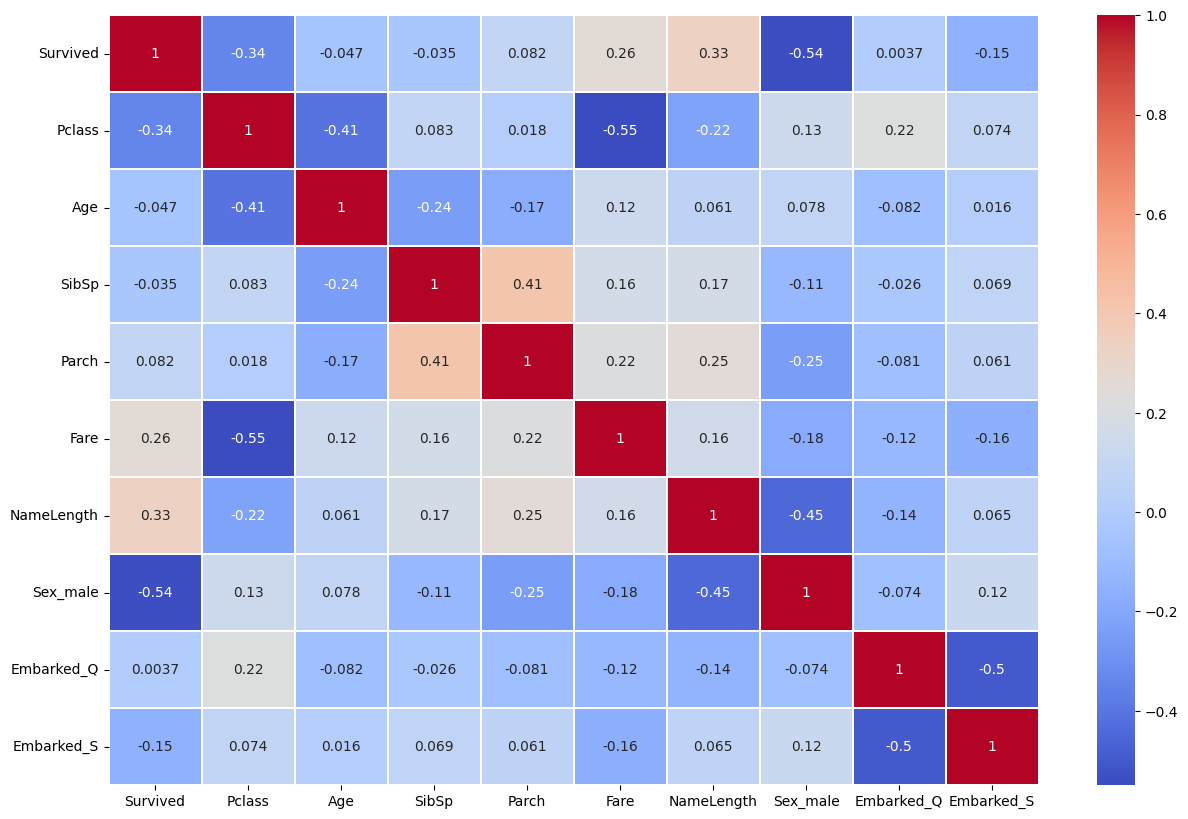

In [120]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=0.2)
plt.show()

**Pergunta 1:** Usando as suas próprias palavras, faça uma análise dos valores de correlação mostrados acima.

**Resposta:** A partir do gráfico, pode-se dizer que:
- A correlação moderada negativa entre a variável *Survived* e a variável *Pclass*  sugere que as classes mais altas têm maior chance de sobreviver ao desastre.
- A correlação positiva leve da variável *Survived* com *Fare* e *NameLength* sugere que pessoas que pagaram tarifas mais altas e que possuíam nomes mais longos têm maior chance de sobreviver ao desastre.
- A correlação forte negativa entre as variáveis *Survived* e *Sex_male* sugere que homens tem menos probabilidade de sobreviver ao desastre. Em outras palavras, mulheres têm melhores chances de sobrevivência.
- *SibSp* e *Parch* têm correlação moderada positiva, sugerindo que são relacionadas.
- As variáveis *Embarked_Q* e *Embarked_S* têm correlação negativa forte, sugerindo exclusão mútua (A pessoa somente pode embarcar por um dos pontos de embarque)
- As variáveis *Embarked_Q*, *Embarked_S* e *Parch* têm correlação fraca com a variável *survived*, sugerindo que estas têm pouca influência sobre o resultado do desastre (sobrevivi ou não? Eis a questão imposta pelo problema)

In [121]:
X_df = df.iloc[:, 1:] # cria novo dataframe com todas as características x1, x2, ..., x10
y_df = df.iloc[:, 0] # cria novo dataframe com valor alvo para todas as amostras

In [122]:
X_df.head()

,Pclass,Age,SibSp,Parch,Fare,NameLength,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,23,1,0,1
1,1,38.0,1,0,71.2833,51,0,0,0
2,3,26.0,0,0,7.9250,22,0,0,1
3,1,35.0,1,0,53.1000,44,0,0,1
4,3,35.0,0,0,8.0500,24,1,0,1


In [123]:
y_df.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [124]:
# Transformando de Dataframe para numpy array:
X = X_df.to_numpy()
y = y_df.to_numpy()

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (891, 9)
y Shape: (891,)


In [125]:
# número de características

n = X.shape[1]

print(f"Número de características: {n}")

Número de características: 9


## Preparando os dados

In [126]:
from sklearn.model_selection import train_test_split

X_trein, X_val, y_trein, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # reservando 20% dos dados para validação


print("X_trein.shape:", X_trein.shape)
print("y_trein.shape:", y_trein.shape)
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)

X_trein.shape: (712, 9)
y_trein.shape: (712,)
X_val.shape: (179, 9)
y_val.shape: (179,)


# Modelo de Regressão Logística treinado usando Scikit Learn

O código abaixo importa a função logistic regression model do scikit-learn e treina um modelo para os dados.


In [127]:
from sklearn.linear_model import LogisticRegression

modelo_RegLog = LogisticRegression()
modelo_RegLog.fit(X_trein, y_trein)

/home/augusto/development/money_carousell/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Fazendo previsões

In [128]:
y_pred = modelo_RegLog.predict(X_trein)

print("Previsão feita para os dados de treinamento:", y_pred)

Previsão feita para os dados de treinamento: [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0
 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0
 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0
 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1
 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1
 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 

## Calculando Taxa de acerto do modelo (acurácia)

Você pode calcular a taxa de acerto (acurácia) do modelo usando a função `score`. A acurácia corresponde ao percentual de amostras que foram corretamente classificadas pelo modelo.

In [129]:
print("Taxa de acerto (acurácia) para os dados de treinamento (%):", 100*modelo_RegLog.score(X_trein, y_trein))

print("Taxa de acerto (acurácia) para os dados de validação (%):", 100*modelo_RegLog.score(X_val, y_val))

Taxa de acerto (acurácia) para os dados de treinamento (%): 79.63483146067416
Taxa de acerto (acurácia) para os dados de validação (%): 82.12290502793296


**Pergunta 2:** Note que a acurácia de validação obtida por este modelo de Regressão Logística foi de **80.44 %**. Compare este valor com o resultado obtido pelos modelos estatísticos anteriores, que não se beseavam em modelos de aprendizado de máquina. Faça uma análise desses resultados.

**Resposta:** O valor obtido pelo modelo de aprendizado de máquina (na hora da execução, 82,12%) é maior que os obtidos nos testes de validação dos modelos estatísticos (78,68%), provavelmente porque o modelo de aprendizado de máquina captura mais detalhes dos dados em si do que os modelos estatisticos mais simples. Embora se obtenha uma taxa elevada com o modelo estatístico, os modelos de aprendizado de máquina têm geralmente melhor performance justamente porque são capazes de explorar os detalhes mais sutis dos dados de forma eficaz.

# Rede neural treinada usando Tensorflow

## Análise do desbalanceamento nos rótulos e atribuição de pesos diferentes

In [130]:
qtdade_amostras_cada_classe = np.bincount(y_trein) # função do numpy que conta a quantidade de amostras para cada classe
print(qtdade_amostras_cada_classe)
print(
    "Número de amostras positivas no conjunto de dados de treinamento: {} ({:.2f}% do total)".format(
        qtdade_amostras_cada_classe[1], 100 * float(qtdade_amostras_cada_classe[1]) / len(y_trein)
    )
)

peso_classe_0 = 1.0 / qtdade_amostras_cada_classe[0]
peso_classe_1 = 1.0 / qtdade_amostras_cada_classe[1]

print("Peso para classe 0:", peso_classe_0 )
print("Peso para classe 1:", peso_classe_1 )

pesos_classes = {0: peso_classe_0, 1: peso_classe_1} # cria um dicionário com o peso de cada classe

[444 268]
Número de amostras positivas no conjunto de dados de treinamento: 268 (37.64% do total)
Peso para classe 0: 0.0022522522522522522
Peso para classe 1: 0.0037313432835820895


## Normalizando os dados usando média e desvio padrão

In [131]:
media    = np.mean(X_trein, axis=0)
X_trein -= media
X_val   -= media
desvio   = np.std(X_trein, axis=0)
X_trein /= desvio
X_val   /= desvio

## Criando uma rede neural para classificação binária

In [132]:
import keras

modelo = keras.Sequential(
    [
        keras.Input(shape=X_trein.shape[1:]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelo.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

Nesse script, quando do treinamento do modelo usando Tensorflow, usaremos 'checkpoint callback' para salvar os melhores pesos encontrados para o modelo. Assim, após o treinamento, podemos usar diretamente o melhor modelo sem a necessidade de retreinar a rede. Para selecionar o melhor modelo, usaremos como métrica de escolha a acurácia de validação.

In [133]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "modelo_titanic.keras",
    save_best_only=True,
    monitor="val_binary_accuracy",  # ou qualquer outra métrica tal como: 'val_precision', 'val_recall', "val_binary_accuracy", "val_loss"
)

Ao usar o ModelCheckpoint com save_best_only=True, o "melhor modelo" é determinado com base na métrica monitorada. Por padrão, o Keras utiliza a perda de validação (val_loss) como métrica para rastrear o melhor modelo. O modelo que obtiver a menor perda de validação durante o treinamento será salvo como o "melhor modelo".

No entanto, você pode especificar uma métrica diferente para monitorar, configurando o parâmetro monitor ao definir o callback ModelCheckpoint. Por exemplo, se você deseja salvar o modelo com a melhor acurácia de validação, pode configurá-lo conforme mostrado acima.

Dessa forma, o ModelCheckpoint salvará o modelo que alcançar a melhor pontuação para a métrica especificada, garantindo que você preserve a versão mais alinhada ao seu objetivo.

In [134]:
METRICS = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]
modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    metrics=METRICS,
)

history = modelo.fit(
    X_trein,
    y_trein,
    epochs=100,
    validation_data=(X_val, y_val),
    class_weight=pesos_classes,
    callbacks=checkpoint_cb
)

Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.6522 - loss: 0.0017 - precision: 0.5458 - recall: 0.7724 - val_binary_accuracy: 0.7989 - val_loss: 0.4032 - val_precision: 0.7500 - val_recall: 0.7703
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7952 - loss: 0.0014 - precision: 0.7028 - recall: 0.6822 - val_binary_accuracy: 0.8212 - val_loss: 0.4113 - val_precision: 0.7625 - val_recall: 0.8243
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8021 - loss: 0.0013 - precision: 0.7438 - recall: 0.7470 - val_binary_accuracy: 0.8045 - val_loss: 0.4558 - val_precision: 0.7097 - val_recall: 0.8919
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8241 - loss: 0.0012 - precision: 0.7487 - recall: 0.8216 - val_binary_accuracy: 0.8156 - val_loss: 0.4415 - val_precision: 0.7470 - val_recall: 0.8378
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8183 - loss: 0.0012 - precision: 0.7317 - recal

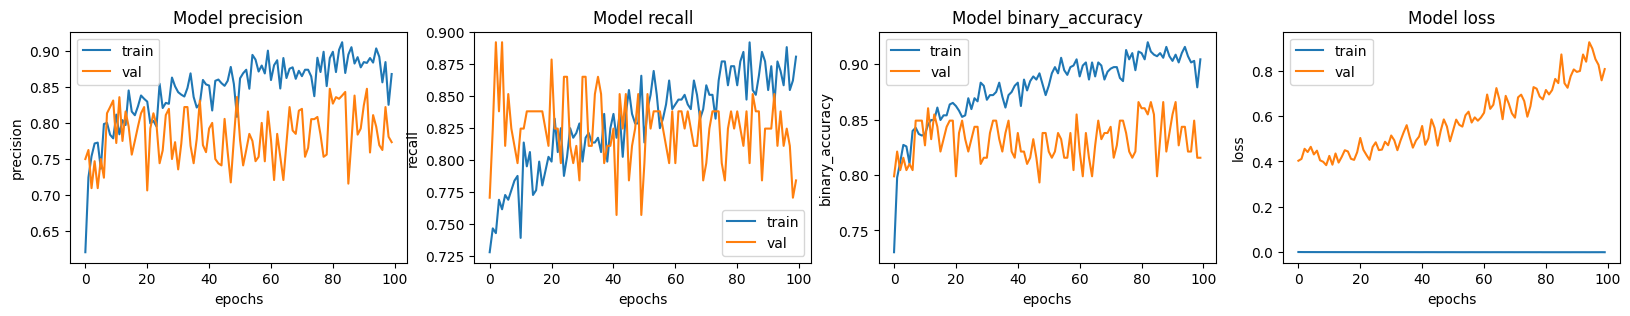

In [135]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

**Pergunta 3:** Usando as suas próprias palavras, faça uma análise detalhada dos gráficos mostrados acima.

**Resposta:** Análise de cada gráfico:
- Precisão: O modelo parece aprender os padrões do conjunto de treinamento, contudo pode sofrer de sobreajuste, pois a precisão para validação não acompanha o desempenho do treinamento $\Rightarrow$ A precisão ao longo das épocas aumenta dirante o treinamento, enquanto a precisão oscila em torno de uma média ao longo das épocas para os dados de validação.
- Recorrência, revocação ou *recall*: o modelo demonstra uma recorrência que aumenta ao longo das épocas, embora oscile de forma semelhante à precisão ao longo das épocas para os dados de validação, reforçando a conclusão de que o modelo está sobreajustado.
- Acurácia binária: A aparência semelhante ao gráfico de precisão sugere que o modelo está sobreajustado ($b_{accval} < b_{acctrein}$).
- Perdas: a perda crescente nos dados de teste, enquanto a perda permanece constante nos dados de treinamento, ao longo das épocas é mais um indicador de sobreajuste.

In [136]:
# Carregando o melhor modelo:

modelo = keras.models.load_model("modelo_titanic.keras")

In [137]:
#modelo.evaluate( (X_val, y_val) , return_dict=True)

In [138]:
probabilidades = modelo.predict(X_trein)
y_trein_est    = (probabilidades >= 0.5).astype(int)
acuracia_trein = np.mean(y_trein.reshape(-1,1) == y_trein_est) * 100
print('Redes Neurais: Taxa de acerto (acurácia) para dados de treinamento:{0:.3f} %'.format(acuracia_trein))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Redes Neurais: Taxa de acerto (acurácia) para dados de treinamento:92.275 %


In [139]:
probabilidades = modelo.predict(X_val)
y_val_est      = (probabilidades >= 0.5).astype(int)
acuracia_val   = np.mean(y_val.reshape(-1,1) == y_val_est) * 100
print('Redes Neurais: Taxa de acerto (acurácia) para dados de validação:{0:.3f} %'.format(acuracia_val))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
Redes Neurais: Taxa de acerto (acurácia) para dados de validação:86.592 %


**Pergunta 4:** Note que a acurácia de validação obtida por esta rede neural foi de cerca de **85 %**.  Compare esta valor com aquele obtido usando Regressão Logística foi de **80.44 %**. Faça uma análise desses resultados.

**Resposta:** O melhor modelo de redes neurais encontrado pelo *keras* consegue performar ainda melhor que o modelo de regressão logística utilizando o *Scikit-Learn*. REsumidamente, a rede neural é capaz de capturar ainda mais detalhes importantes para a determinação da sobrevivência da pessoa utilizando os dados fornecidos. Contudo, a diferença entre a precisão de treino e teste (92,275% e 86,592%) é indicador de sobreajuste. Porém, a acurácia é cerca de 4% maior que com o modelo de regressão logística (82,12 % contra 86,59%) devido ao modelo capturar melhor detalhes sutis nos dados de forma eficaz.

## Matriz de confusão resultante

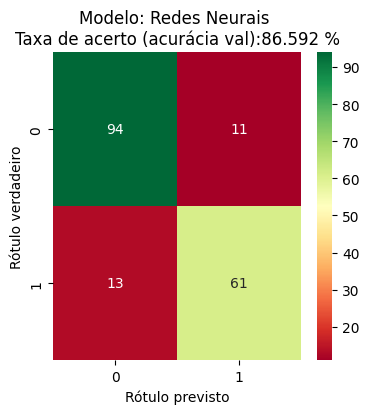

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True,cmap='RdYlGn')
plt.title('Modelo: Redes Neurais \nTaxa de acerto (acurácia val):{0:.3f} %'.format(acuracia_val))
plt.ylabel('Rótulo verdadeiro')
plt.xlabel('Rótulo previsto')
plt.show()

In [141]:
# calculando precisão, recall e f1 score

rotulos = ["y=0","y=1"]

tp        = np.diag(cm) # Diagonal represents true positives
precisao  = dict()
revocacao = dict()
f1_score  = dict()
for i in range(len(rotulos)):
  col = cm[:, i]
  fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

  row = cm[i, :]
  fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

  valor_precisao  = tp[i] / (tp[i] + fp)
  valor_revocacao = tp[i] / (tp[i] + fn)
  valor_f1_score  = 2*valor_precisao*valor_revocacao / (valor_precisao + valor_revocacao)

  precisao[rotulos[i]] = valor_precisao
  revocacao[rotulos[i]]    = valor_revocacao
  f1_score[rotulos[i]]  = valor_f1_score

print("precisao: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

precisao:  {'y=0': 0.8785046728971962, 'y=1': 0.8472222222222222}
recall:  {'y=0': 0.8952380952380953, 'y=1': 0.8243243243243243}
F1 score:  {'y=0': 0.8867924528301887, 'y=1': 0.8356164383561645}


**Pergunta 5:** Usando as suas próprias palavras, faça uma análise da matriz de confusão resultante, assim como das métricas de precisão, revocação, e F1 score obtidas.

**Resposta:** A matriz de confusão apresenta os seguintes dados:
- Verdadeiros Positivos (TP, y=1): 61
- Verdadeiros Negativos (TN, y=0): 94
- Falsos Positivos (FP): 11
- Falsos Negativos (FN): 13

As métricas *precisão*, *revocação* e *F1 Score*, calculados a partir desta matriz de confusão são mostrados na tabela a seguir:

| Métrica      | Classe 0 (y=0) | Classe 1 (y=1) |
|--------------|----------------|----------------|
| Precisão     | 0.8785         | 0.8472         |
| Recall       | 0.8952         | 0.8243         |
| F1 Score     | 0.8868         | 0.8356         |

O modelo apresenta bom equilíbrio entre precisão e recall para a classe positiva ($y=1$), com precisão de 84,7%, *recall* de 82,4% e *F1 Score* de 83,6%, identificando a maioria dos casos positivos, embora haja 13 falsos negativos. Para a classe negativa ($y=0$), o modelo interpreta bem os casos negativos, embora ainda cometa 11 falsos positivos, com precisão de 87,8%, *recall* de 89,5% e *F1 Score* de 88,7%.

Os valores das métricas (precisão, *recall* e *F1 Score*) são próximos entre si e têm valores maiores que 80% para ambas as classes, o que indica equilíbrio e bom desempenho, mas há espaço para melhorias, especialmente na redução de falsos negativos e falsos positivos. A diminuição de *TP* e *TN* aumentaria, sistematicamente, as métricas supra citadas. A geração de dados sintéticos seria uma alternatica para a diminuição dos falsos positivos e negativos: com o aumento de dados consegue-se equilibrar melhor a significância entre as classes e obter um treinamento melhor por simplesmente ter mais dados disponíveis. Contudo, deve-se evitar impor tendências tais como, em alguns casos, o algoritmo *SMOTE* introduz. 

# Fim